Precompute separate log signatures for each of the highlited brain regions:

<img src="../images/brain_regions.png" style="width: 200px;"/>

In [1]:
import numpy as np
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
from signature_transform_utils import modify_metadata, preprocess_for_sig, calculate_logsignature_for_metadata, calculate_signature_for_metadata, butter_bandpass_filter
import signatory
import torch

/home/barbora/.local/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
TRAIN_EEG_DIR = "../../data/train_eegs/"
TRAIN_METADATA_DIR = "../../data/train.csv"
TRAIN_SIGNATURES_DIR = "../../data/train_signatures/"

In [3]:
train_metadata = pd.read_csv(TRAIN_METADATA_DIR)
train_metadata = modify_metadata(train_metadata)

In [4]:
train_metadata

,eeg_id,spectrogram_id,eeg_offset_seconds,spec_offset_seconds,patient_id,target,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,789577333,9.0,9.0,20654,Other,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333
1,582999,1552638400,18.0,18.0,20230,LPD,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429
2,1895581,128369999,0.0,1138.0,47999,Other,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154
3,2482631,978166025,24.0,1926.0,20606,Other,0.000000,0.000000,0.133333,0.066667,0.133333,0.666667
4,2521897,673742515,2.0,2.0,62117,Other,0.000000,0.000000,0.083333,0.083333,0.333333,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
5934,4291430584,1984115527,15.0,565.0,61174,LPD,0.000000,0.687500,0.000000,0.000000,0.000000,0.312500
5935,4291744526,677970444,14.0,14.0,15506,GRDA,0.000000,0.125000,0.000000,0.000000,0.500000,0.375000
5936,4292809326,75243787,12.0,12.0,18815,Other,0.000000,0.000000,0.000000,0.000000,0.083333,0.916667
5937,4293306306,819682076,0.0,168.0,37409,GPD,0.000000,0.066667,0.400000,0.000000,0.133333,0.400000


<Axes: xlabel='target'>

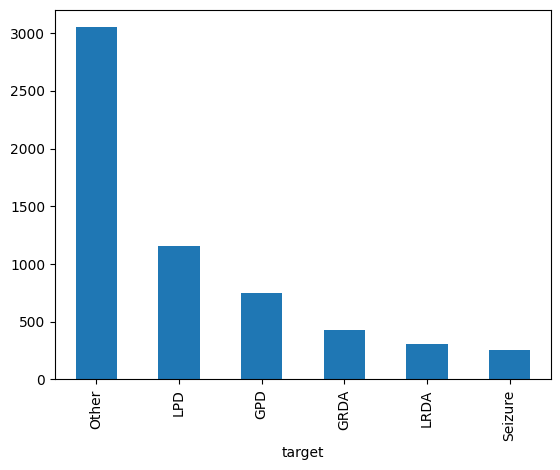

In [5]:
train_metadata.target.value_counts().plot(kind='bar')

In [6]:
preprocessed = preprocess_for_sig(train_metadata.head(100), TRAIN_EEG_DIR, scaler_type="meanvarPerChannel_1.0")

In [7]:
preprocessed[:4, :, :4].std()

0.9936438108135426

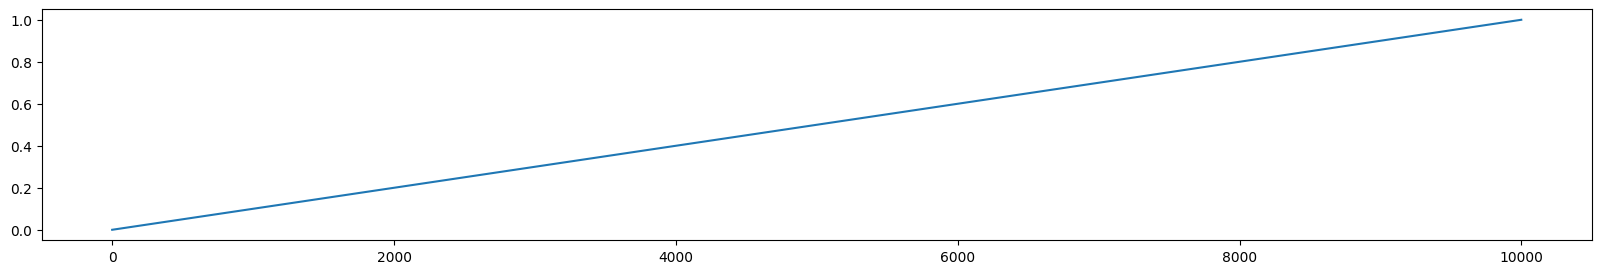

In [8]:
# example of a preprocessed eeg signal
plt.figure(figsize=(20,3))
plt.plot(preprocessed[16,:,4])

In [9]:
scaler_types = ["meanvarPerChannel_1.0"]
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
def calculate_and_store_sigs(scaler_type):
    """Calculate and store signatures up to level 5 for the given scaler type"""
    calculate_signature_for_metadata(train_metadata, TRAIN_EEG_DIR, TRAIN_SIGNATURES_DIR, scaler_type = scaler_type, batch_size=1000, device=device, level=5)
    for i in range(0, len(train_metadata), 1000):
        sigs = torch.load(f"{TRAIN_SIGNATURES_DIR}sigs_lvl_5_scaler_{scaler_type}_{i}.pt")
        if i == 0:
            all_sigs = sigs
        else:
            all_sigs = torch.cat((all_sigs, sigs), 0)
    torch.save(all_sigs, f"{TRAIN_SIGNATURES_DIR}all_sigs_lvl_5_scaler_{scaler_type}_experts.pt")
    print(f"Done with {scaler_type}")

In [11]:
for scaler_type in scaler_types:
    calculate_and_store_sigs(scaler_type)

Processed 0 records.
Processed 1000 records.
Processed 2000 records.
Processed 3000 records.
Processed 4000 records.
Processed 5000 records.
Done with meanvarPerChannel_1.0


In [12]:
# also store level 4, 3
sig_4_dim = signatory.signature_channels(5, 4)
sig_3_dim = signatory.signature_channels(5, 3)

In [13]:
for scaler_type in scaler_types:
    lvl_5_sigs = torch.load(f"{TRAIN_SIGNATURES_DIR}all_sigs_lvl_5_scaler_{scaler_type}_experts.pt")
    lvl_4_sigs = lvl_5_sigs[:,:,0:sig_4_dim]
    lvl_3_sigs = lvl_5_sigs[:,:,0:sig_3_dim]
    torch.save(lvl_4_sigs, f"{TRAIN_SIGNATURES_DIR}all_sigs_lvl_4_scaler_{scaler_type}_experts.pt")
    torch.save(lvl_3_sigs, f"{TRAIN_SIGNATURES_DIR}all_sigs_lvl_3_scaler_{scaler_type}_experts.pt")
    print(f"Done with {scaler_type}")

Done with meanvarPerChannel_1.0
